In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# load data
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
df = pd.read_excel('~/nfl_dashboard/ml_models/data/wr_data.xlsx')
df.drop(['Clean_Name','NFL_POS','DR','Y1_PPR_PPG','G_Y1','G_Y2','G_Y3','Y1_PPR_Pts','Pts_Y2','Pts_Y3','Y1-Y3_Total_PPR'], axis=1, inplace=True)
df.sort_values(by='Draft_Year', ascending=False, inplace=True, ignore_index=True)

# split data
labels_all = df.iloc[:, 0:5]
x_all = df.iloc[:, 5:-2] # all features
y_all = df.iloc[:, -1:] # all y data
train_x = df.iloc[149:, 5:-2] # features with at least 3 nfl years
train_y = df.iloc[149:, -1:] # y data with at least 3 nfl years

In [3]:
# remove highly collinear features, keeping the feature w/strongest correlation to y-var
corr_thres = .70
drop_cntr = i = j_flag = i_flag = 0

while i < len(train_x.columns):
    j = i+1
    while j < len(train_x.columns):
        if (abs(train_x[train_x.columns[i]].corr(train_x[train_x.columns[j]])) > corr_thres):
            if abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) <= abs(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))):
                print("deleted:", train_x.columns[i], " {0:.2f}%".format(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),
                      "\nkept:\t", train_x.columns[j], " {0:.2f}%".format(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),"\n");
                train_x = train_x.drop(train_x.columns[i], axis=1)
                x_all = x_all.drop(x_all.columns[i], axis=1)
                drop_cntr += 1
                i_flag = 1
                break
            else:
                print("deleted:", train_x.columns[j], " {0:.2f}%".format(train_x[train_x.columns[j]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),
                      "\nkept:\t", train_x.columns[i], " {0:.2f}%".format(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))*100),"\n");
                train_x = train_x.drop(train_x.columns[j], axis=1)
                x_all = x_all.drop(x_all.columns[j], axis=1)
                drop_cntr += 1
                j_flag = 1
        if j_flag == 0:
            j += 1
        j_flag = 0
    if i_flag == 0:
        i += 1
    i_flag = 0
                                                                                            
print('\033[1m' + '> ' + str(drop_cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

deleted: BOA_30%  -23.35% 
kept:	 BOA_20%  -24.89% 

deleted: Career_REC/g  31.65% 
kept:	 AVG__RecYds/TmPatt_Above_Conference_Avg  37.65% 

deleted: Career_College_Dominator_Rating  22.48% 
kept:	 Career_Weighted_Dominator  24.98% 

deleted: Career_Weighted_Dominator  24.98% 
kept:	 Career_Yards_Dominator  26.26% 

deleted: Best_RecYds/TmPatt  33.29% 
kept:	 Career_YPTpA_Dominator  34.24% 

deleted: Last_RecYds/TmPatt  34.06% 
kept:	 Career_YPTpA_Dominator  34.24% 

deleted: Career_YPTpA_Dominator  34.24% 
kept:	 AVG_RecYds/TmPatt  37.82% 

deleted: Career_Yards_Dominator  26.26% 
kept:	 AVG_RecYds/TmPatt  37.82% 

deleted: First_RecYds/TmPatt_Above_Conference_AVg  18.40% 
kept:	 First_RecYds/TmPatt  21.38% 

deleted: First_RecYds/TmPatt  21.38% 
kept:	 AVG__RecYds/TmPatt_Above_Conference_Avg  37.65% 

deleted: Best_RecYds/TmPatt_Above_Conference_Avg  37.02% 
kept:	 AVG_RecYds/TmPatt  37.82% 

deleted: Last__RecYds/TmPatt_Above_Conference_Avg  37.21% 
kept:	 AVG_RecYds/TmPatt  37.82% 

In [4]:
# #drop features with low correlation
# corr_threshold = .05
# cntr = i = 0

# while i < len(train_x.columns):
#     if(abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64'))) < corr_threshold):
#         print(train_x.columns[i])
#         train_x = train_x.drop(train_x.columns[i], axis=1)
#         x_all = x_all.drop(x_all.columns[i], axis=1)
    
#         cntr += 1
#     else:
#         i += 1

# print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
# print('\033[1m' + '> ' + str(len(train_x.columns)) + ' features remain.' + '\033[0m')

In [5]:
train_x.isna().sum()

DP                                                             0
Age_In_Draft_Yr                                                0
BOA_20%                                                      169
Career_YPR                                                     0
AVG__RecYds/TmPatt_Above_AGE_Avg                              70
First_RecYds/TmPatt_Above_Experience_Avg.1                   130
Best_RecYds/TmPatt_Above_Experience_Avg.1                    130
First_MS_rec_Yards                                             4
AVG_MS_TDs                                                    34
TeamMate_Score                                                32
Career_RecTd/GP                                                0
Avg_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games      0
Last_Player_Above/Below_AVG_Team_REC_Yds_MS                    0
Last_Team_Adjusted_YTMpA                                       0
BMI                                                          226
bench                    

In [6]:
# manual drops

list_to_drop = ['BMI','bench','3Cone','shuttle','vert','WaSS']
cntr = 0

for i in list_to_drop:
    x_all = x_all.drop(i, axis=1)
    train_x = train_x.drop(i, axis=1)
    cntr += 1


print('\033[1m' + '> ' + str(cntr) + ' features were deleted.' + '\033[0m')
print('\033[1m' + '> ' + str(len(x_all.columns)) + ' features remain.' + '\033[0m')

> 6 features were deleted.
> 16 features remain.


In [7]:
# print correlations
i = 0
while i < len(train_x.columns):
    corr = abs(train_x[train_x.columns[i]].astype('float64').corr(train_y[train_y.columns[0]].astype('float64')))
    print(train_x.columns[i],": {0:.2f}%".format(corr*100),sep='')
    i += 1

DP: 63.46%
Age_In_Draft_Yr: 28.73%
BOA_20%: 24.89%
Career_YPR: 13.74%
AVG__RecYds/TmPatt_Above_AGE_Avg: 46.65%
First_RecYds/TmPatt_Above_Experience_Avg.1: 24.17%
Best_RecYds/TmPatt_Above_Experience_Avg.1: 35.80%
First_MS_rec_Yards: 22.66%
AVG_MS_TDs: 26.84%
TeamMate_Score: 1.52%
Career_RecTd/GP: 34.61%
Avg_Player_Above/Below_AVG_Conference_REC_Yds_MS_>6_games: 22.41%
Last_Player_Above/Below_AVG_Team_REC_Yds_MS: 7.86%
Last_Team_Adjusted_YTMpA: 31.31%
Burst_Score: 9.82%
Adjusted_40_Time: 14.77%


<AxesSubplot:>

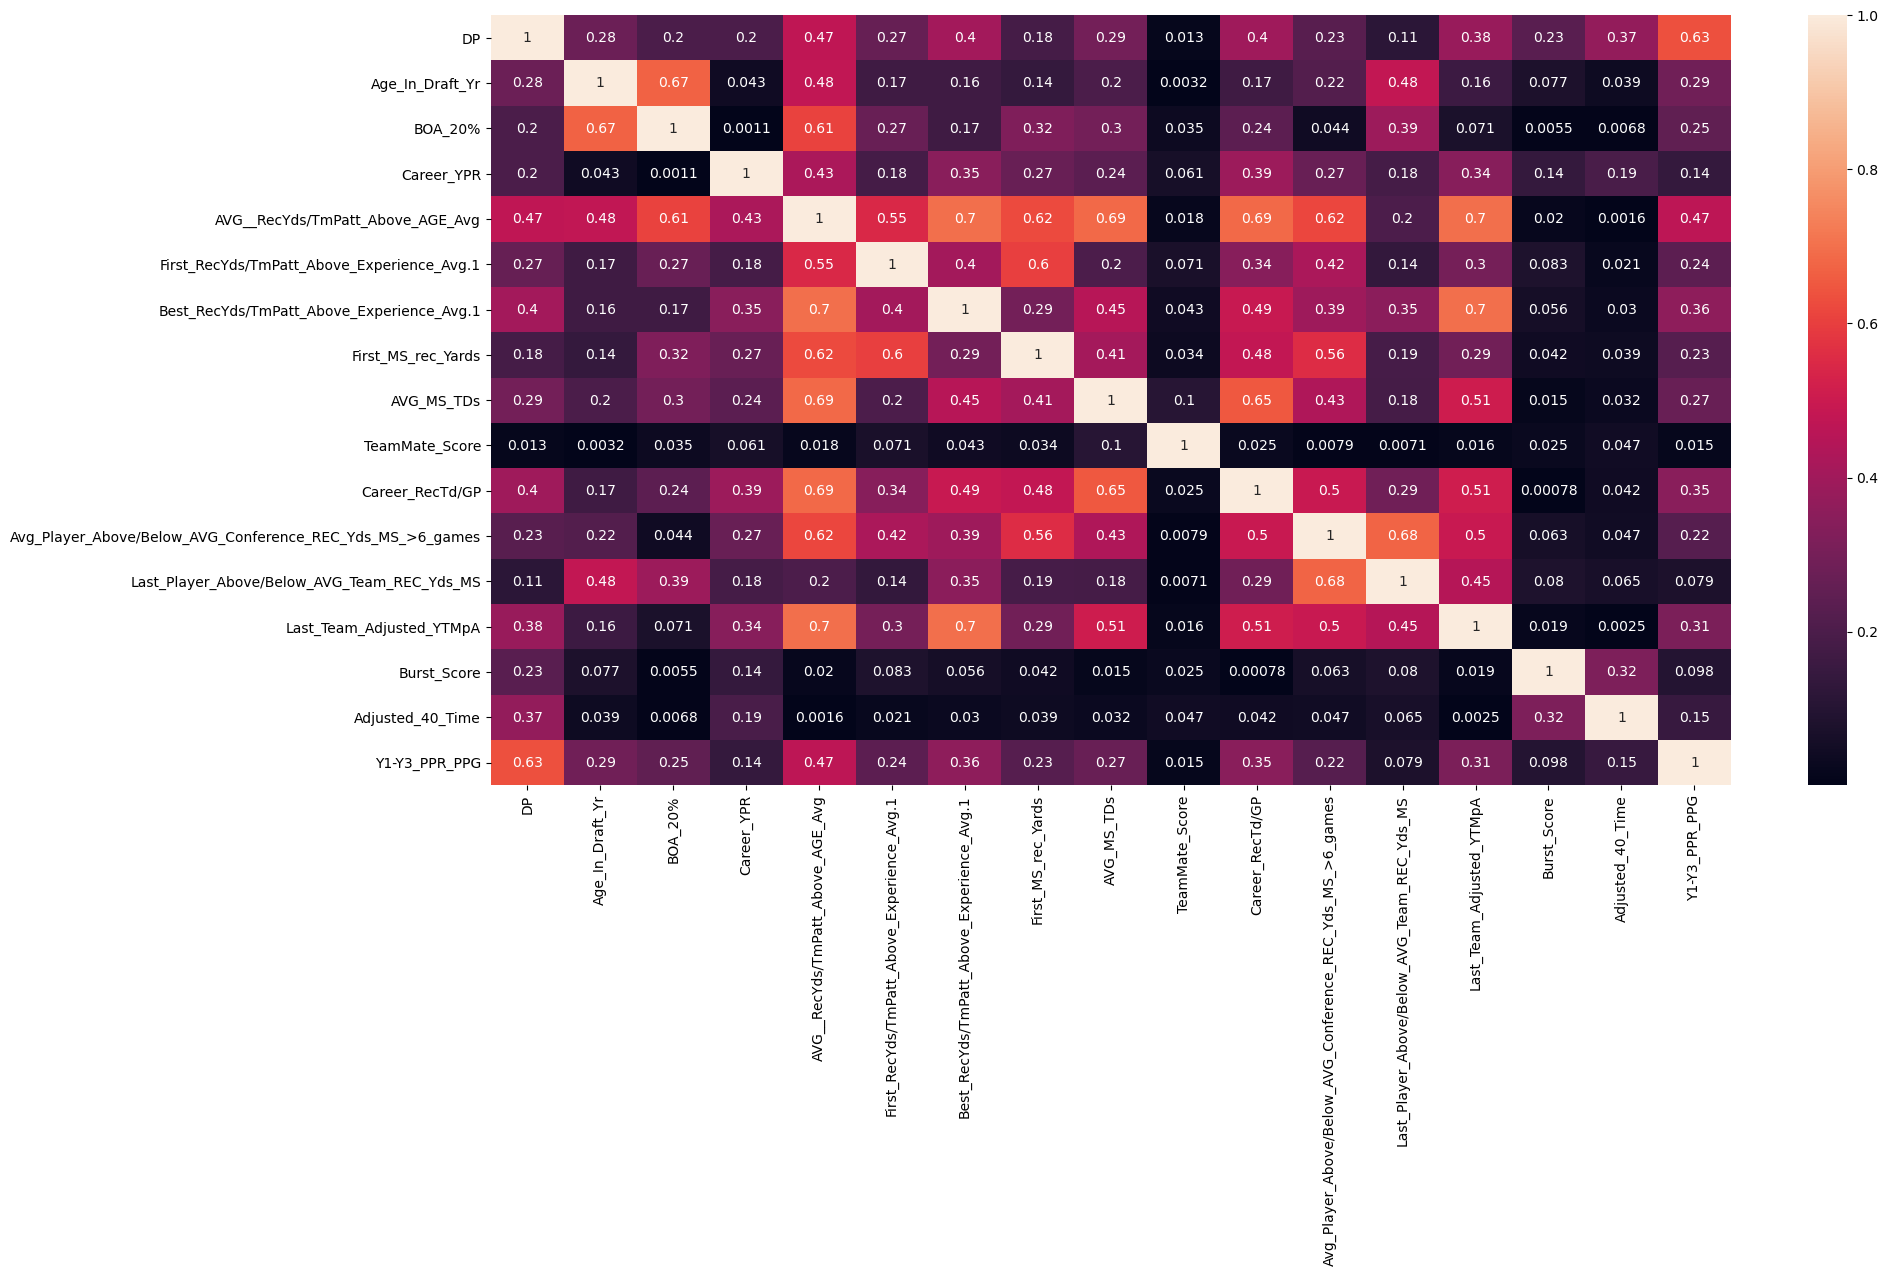

In [8]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(abs(train_x.join(train_y).astype('float64').corr()), annot=True)

Text(0.5, 1.0, 'Distribution of NFL Total WR PPR PPG')

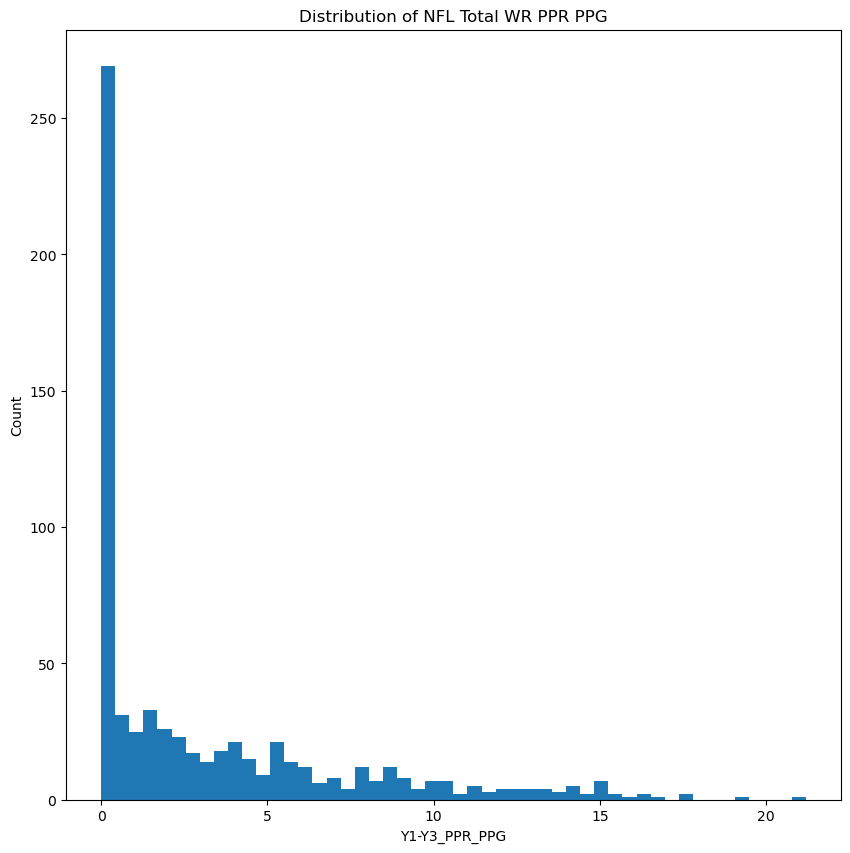

In [9]:
# Look at distribution of target variable -> very positibly skewed
plt.rcParams["figure.figsize"] = (10, 10)
plt.hist(train_y['Y1-Y3_PPR_PPG'], bins = 50)
plt.xlabel('Y1-Y3_PPR_PPG')
plt.ylabel('Count')
plt.title('Distribution of NFL Total WR PPR PPG')

In [10]:
len(train_x)

676

Len X_train: 507
Len X_test: 169


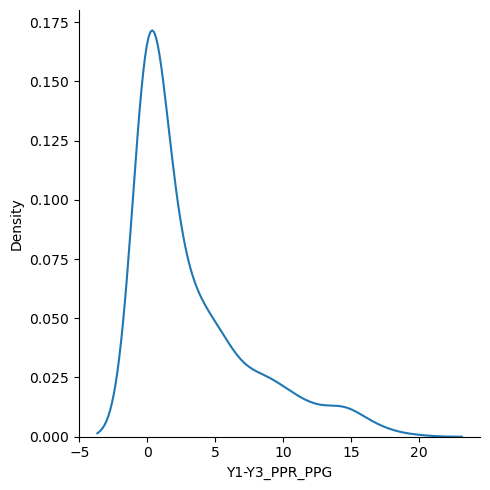

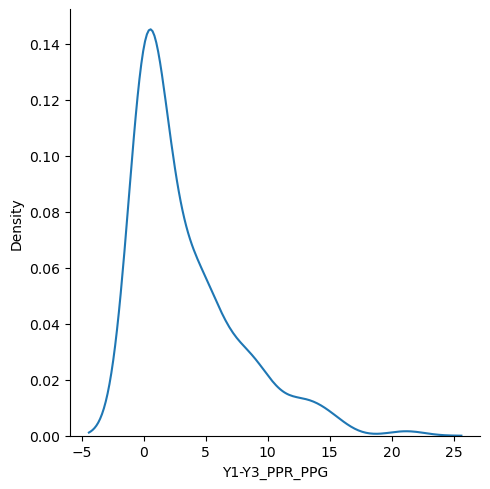

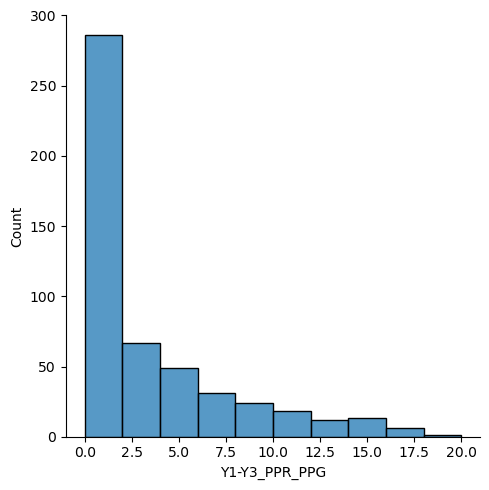

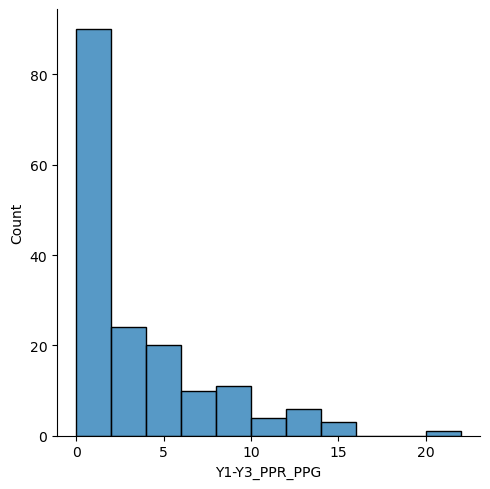

In [11]:
# stratified split of continous data
# Create the bins.  My `y` variable has
# 677 observations, and I want 50 bins.

bins = np.linspace(0, 676, 30)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(train_y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.25, shuffle=True, stratify=y_binned, random_state=10)
print("Len X_train:", len(X_train))
print("Len X_test:", len(X_test))
sns.displot(y_train, x="Y1-Y3_PPR_PPG", kind="kde")
sns.displot(y_test, x="Y1-Y3_PPR_PPG", kind="kde")
sns.displot(y_train, x="Y1-Y3_PPR_PPG",binwidth=2)
sns.displot(y_test, x="Y1-Y3_PPR_PPG",binwidth=2)

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.reset_option('all')

In [14]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

xgb_model = XGBRegressor(verbosity=0)
params = {'n_estimators': [150,200,300],
          'max_depth': [2,3],
          'learning_rate': [0.01,0.005],
          'gamma': [10],
          'subsample': [0.7,0.85,1],
          'colsample_bytree': [1],
          'base_score': [0]}
reg = GridSearchCV(estimator = xgb_model, 
             param_grid = params,
             scoring='neg_mean_absolute_error', 
             n_jobs=-1, 
             refit=True, 
             cv=4, 
             verbose=2)

reg.fit(train_x, train_y.astype('float64'))
print('done')

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inste

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

done


In [16]:
reg.best_params_

{'base_score': 0,
 'colsample_bytree': 1,
 'gamma': 10,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 200,
 'subsample': 0.85}

[0]	validation_0-mae:3.20483	validation_1-mae:3.24808
[1]	validation_0-mae:3.18333	validation_1-mae:3.22291
[2]	validation_0-mae:3.16211	validation_1-mae:3.19696
[3]	validation_0-mae:3.14145	validation_1-mae:3.17247
[4]	validation_0-mae:3.11935	validation_1-mae:3.14790
[5]	validation_0-mae:3.09737	validation_1-mae:3.12291
[6]	validation_0-mae:3.07560	validation_1-mae:3.09705
[7]	validation_0-mae:3.05438	validation_1-mae:3.07253
[8]	validation_0-mae:3.03422	validation_1-mae:3.05057
[9]	validation_0-mae:3.01330	validation_1-mae:3.02720
[10]	validation_0-mae:2.99349	validation_1-mae:3.00551
[11]	validation_0-mae:2.97550	validation_1-mae:2.98265
[12]	validation_0-mae:2.95726	validation_1-mae:2.95949
[13]	validation_0-mae:2.93798	validation_1-mae:2.93827
[14]	validation_0-mae:2.91873	validation_1-mae:2.91535
[15]	validation_0-mae:2.90037	validation_1-mae:2.89420
[16]	validation_0-mae:2.88203	validation_1-mae:2.87024
[17]	validation_0-mae:2.86406	validation_1-mae:2.84648
[18]	validation_0-ma

[149]	validation_0-mae:1.83150	validation_1-mae:1.88382
[150]	validation_0-mae:1.82874	validation_1-mae:1.88076
[151]	validation_0-mae:1.82619	validation_1-mae:1.87879
[152]	validation_0-mae:1.82430	validation_1-mae:1.87833
[153]	validation_0-mae:1.82217	validation_1-mae:1.87722
[154]	validation_0-mae:1.82030	validation_1-mae:1.87616
[155]	validation_0-mae:1.81771	validation_1-mae:1.87453
[156]	validation_0-mae:1.81597	validation_1-mae:1.87406
[157]	validation_0-mae:1.81297	validation_1-mae:1.87174
[158]	validation_0-mae:1.81037	validation_1-mae:1.87119
[159]	validation_0-mae:1.80801	validation_1-mae:1.87036
[160]	validation_0-mae:1.80598	validation_1-mae:1.86979
[161]	validation_0-mae:1.80359	validation_1-mae:1.87012
[162]	validation_0-mae:1.80144	validation_1-mae:1.87019
[163]	validation_0-mae:1.79939	validation_1-mae:1.86925
[164]	validation_0-mae:1.79711	validation_1-mae:1.86812
[165]	validation_0-mae:1.79580	validation_1-mae:1.86800
[166]	validation_0-mae:1.79311	validation_1-mae:

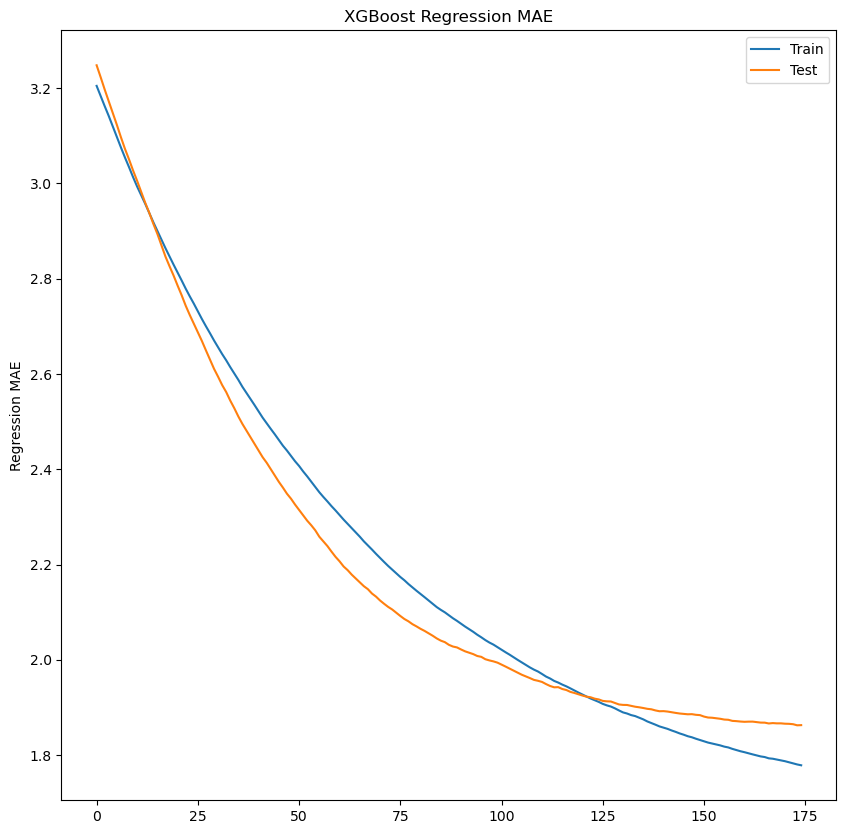

In [20]:
# from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error

xgb_model = XGBRegressor(learning_rate=.01, 
                         gamma=10, 
                         n_estimators=175, 
                         max_depth=3, 
                         subsample=0.8, 
                         colsample_bytree=1, 
                         base_score=0)

eval_set = [(X_train, y_train.astype('float64')),(X_test, y_test.astype('float64'))]

xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, verbose=True) 
#xgb_model.fit(X_train, y_train.astype('float64'), early_stopping_rounds=20, eval_metric='mae', eval_set=eval_set, verbose=True)

y_pred = xgb_model.predict(X_test) 
mae = mean_absolute_error(y_test.astype('float64'), y_pred) 
print("mae: " + str(mae))

from matplotlib import pyplot
#retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mae']) 
x_axis = range(0, epochs)
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Regression MAE')
pyplot.title('XGBoost Regression MAE')
#pyplot.ylim(0,4.25)
pyplot.show()

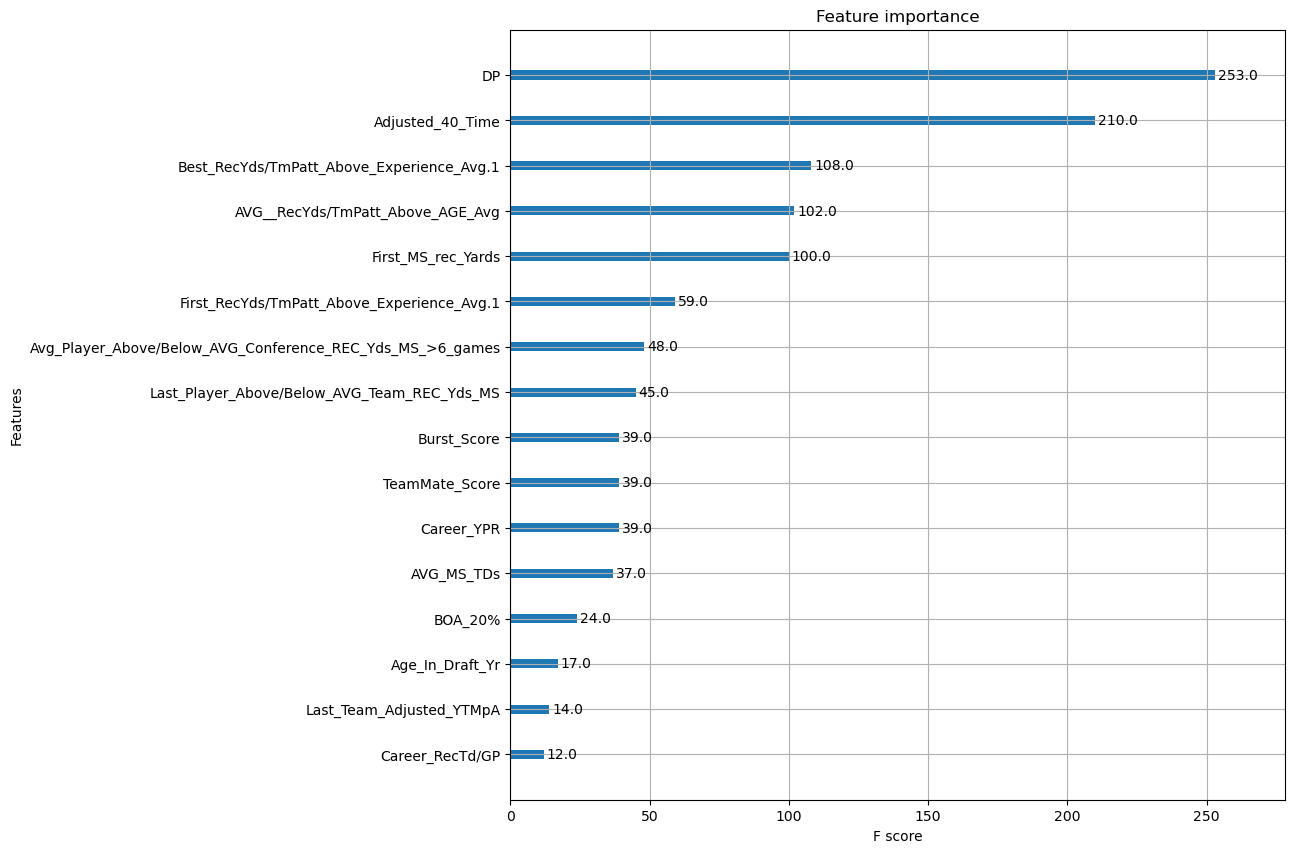

In [21]:
from xgboost import plot_importance
xgb_model.fit(train_x, train_y.astype('float64'))
plt.rcParams['figure.figsize'] = [10, 10]
plot_importance(xgb_model)
plt.show()

In [22]:
preds = pd.DataFrame(xgb_model.predict(x_all))

In [23]:
def red_background_2022(cell_value):
    highlight = 'background-color: red;'
    default = ''
    if cell_value == 2022:
        return highlight
    else:
        return default     

In [25]:
pd.set_option('display.max_rows', 10000) 
pd.set_option('display.max_columns', 1000)
results = labels_all.join(preds)
results = results.join(y_all)
#pd.set_option('precision', 3)
results = results.join(x_all.iloc[:,:1])
results.rename(columns={0:'Pred'}, inplace=True )
results['Percentile Rank'] = results.Pred.rank(pct = True)
results = results.sort_values(by=['Pred'], ascending=False).reset_index(drop=True)
results = results.sort_values(by=['Draft_Year','Pred'], ascending=False).reset_index(drop=True)
results.loc[:, "Pred"] = results["Pred"].map('{:.2f}'.format)
cm = sns.color_palette("inferno", as_cmap=True)
results.style.background_gradient(cmap=cm, subset='Pred').background_gradient(cmap=cm, subset='Y1-Y3_PPR_PPG').applymap(red_background_2022).set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector = 'th', props=[('text-align', 'center')])])
results.head(1000)

Name                  School         Conference  \
0              Jordan Addison              Pittsburgh      ACC (Coastal)   
1            Quentin Johnston         Texas Christian             Big 12   
2                  Josh Downs          North Carolina      ACC (Coastal)   
3              Kayshon Boutte         Louisiana State         SEC (West)   
4          Jaxon Smith-Njigba              Ohio State     Big Ten (East)   
5                 Zay Flowers          Boston College     ACC (Atlantic)   
6                 Jalin Hyatt               Tennessee         SEC (East)   
7                 Marvin Mims                Oklahoma             Big 12   
8                Dontay Demus                Maryland     Big Ten (East)   
9               Rakim Jarrett                Maryland     Big Ten (East)   
10                Jayden Reed          Michigan State     Big Ten (East)   
11              Marcus Rosemy                 Georgia         SEC (East)   
12                  Ajou Ajou                 Clemson     ACC (Atlantic)   
13               Demond Demas               Texas A&M         SEC (West)   
14             Julian Fleming              Ohio State     Big Ten (East)   
15          Parker Washington              Penn State     Big Ten (East)   
16             Jalen McMillan              Washington     Pac-12 (North)   
17             Donavon Greene             Wake Forest     ACC (Atlantic)   
18                Lavel Davis                Virginia      ACC (Coastal)   
19               Jaden Walley       Mississippi State         SEC (West)   
20              E.J. Williams                 Clemson     ACC (Atlantic)   
21            Jermaine Burton                 Georgia         SEC (East)   
22              Treylon Burks                Arkansas         SEC (West)   
23                 Skyy Moore        Western Michigan         MAC (West)   
24          Wan'Dale Robinson                Kentucky         SEC (East)   
25               Drake London     Southern California     Pac-12 (South)   
26               Jahan Dotson              Penn State     Big Ten (East)   
27           Jameson Williams                 Alabama         SEC (West)   
28             Garrett Wilson              Ohio State     Big Ten (East)   
29              Jalen Tolbert           South Alabama    Sun Belt (West)   
30                Alec Pierce              Cincinnati    American (East)   
31                Chris Olave              Ohio State     Big Ten (East)   
32             George Pickens                 Georgia         SEC (East)   
33            Tyquan Thornton                  Baylor             Big 12   
34           Christian Watson            N. Dakota ST                FCS   
35               John Metchie                 Alabama         SEC (West)   
36                 David Bell                  Purdue     Big Ten (West)   
37            Velus Jones Jr.               Tennessee         SEC (East)   
38                 Danny Gray      Southern Methodist    American (West)   
39              Khalil Shakir             Boise State     MWC (Mountain)   
40                Justyn Ross                 Clemson     ACC (Atlantic)   
41                Romeo Doubs                  Nevada         MWC (West)   
42             Dai'Jean Dixon             Nicholls ST                FCS   
43          Calvin Austin III                 Memphis    American (West)   
44                 Makai Polk       Mississippi State         SEC (West)   
45             Jaivon Heiligh        Coastal Carolina    Sun Belt (East)   
46                 Tre Turner           Virginia Tech      ACC (Coastal)   
47                 Mike Woods                Oklahoma             Big 12   
48               Samori Toure                Nebraska     Big Ten (West)   
49              Erik Ezukanma              Texas Tech             Big 12   
50                 K.D. Nixon     Southern California     Pac-12 (South)   
51              Isaiah Weston                 N. Iowa                FCS 

In [27]:
results.to_excel("~/Desktop/wr_1-3_xgb.xlsx")  

In [28]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train.iloc[:,:1],y_train)
y_pred = lr_model.predict(X_test.iloc[:,:1])
mae = mean_absolute_error(y_test, y_pred)
print("MAE of Draft Pick Linear Regression: " + str(mae))

MAE of Draft Pick Linear Regression: 2.3227552762368013
